# Natural Language Processing with Deep Learning

__This is exactly the same notebook as in `../week10_textconv/.`__

__Feel free submit the seminar notebook, just make sure you read the assignments at the end.__

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
27549,67904631,Software Developer PHP,Aatom are now urgently looking to recruit an e...,"Bedford, Bedfordshire",Bedford,NaN,permanent,Aatom Recruitment,IT Jobs,25000 - 35000/annum,30000,cv-library.co.uk,10.308986
45591,68547252,Business Systems Support,My market leading client is looking for a Busi...,West Bromwich,West Bromwich,full_time,NaN,Experis IT,IT Jobs,30000,30000,careerbuilder.com,10.308986
94379,69199182,Early Years Manager/ Instructor,MultiActivity Day Camps part of the Super Cam...,UK,UK,full_time,permanent,Multi Activity,Other/General Jobs,From 251.15 to 350 per week,14427,fish4.co.uk,9.576926


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
27549,67904631,Software Developer PHP,Aatom are now urgently looking to recruit an e...,"Bedford, Bedfordshire",Bedford,NaN,permanent,Aatom Recruitment,IT Jobs,25000 - 35000/annum,30000,cv-library.co.uk,10.308986
45591,68547252,Business Systems Support,My market leading client is looking for a Busi...,West Bromwich,West Bromwich,full_time,NaN,Experis IT,IT Jobs,30000,30000,careerbuilder.com,10.308986
94379,69199182,Early Years Manager/ Instructor,MultiActivity Day Camps part of the Super Cam...,UK,UK,full_time,permanent,Multi Activity,Other/General Jobs,From 251.15 to 350 per week,14427,fish4.co.uk,9.576926


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object
Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object
After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" fields
for col in text_columns:
    for item in data[col]:
        words = item.split(' ')
        token_counts.update(words)

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('imseniorinfrastructureengineercitrix_job', 1)
('carouse', 1)
('mbettleyteksystems', 1)
Correct!
Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('imseniorinfrastructureengineercitrix_job', 1)
('carouse', 1)
('mbettleyteksystems', 1)
Correct!


Text(0.5,0,'Counts')

Text(0.5,0,'Counts')

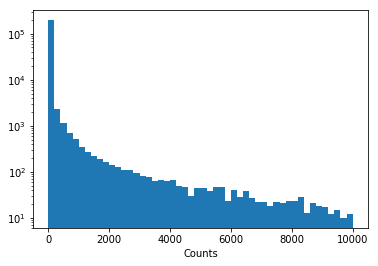

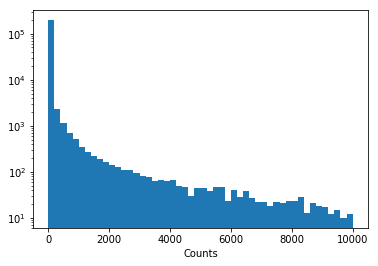

In [8]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = []
for key in sorted(token_counts.keys()):
    if token_counts[key] >= min_count:
        tokens.append(key)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!
Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = {tokens[i] : i for i in range(len(tokens))}

In [12]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!
Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477
Train size =  220291
Validation size =  24477


In [17]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [18]:
temp_batch = generate_batch(data_train, 3, max_len=10)

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [19]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]
    
class GlobalAveragePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.mean(dim=self.dim)

class GlobalSoftmaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return (x * F.softmax(x, dim=self.dim)).sum(dim = self.dim)
    
class GlobalAttentivePoolingOneLayer(nn.Module):
    def __init__(self, dim=-1, out_size=64):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.conv1 = nn.Conv1d(out_size, out_size, kernel_size=3, padding=1)
    
    def forward(self, x):
        pred = self.conv1(x)
        return (x * F.softmax(pred, dim=self.dim)).sum(dim = self.dim)

class GlobalAttentivePoolingTwoLayer(nn.Module):
    def __init__(self, dim=-1, out_size=64):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.conv1 = nn.Conv1d(out_size, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(out_size, out_size, kernel_size=3, padding=1)
        self.do = nn.Dropout(0.1)
    
    def forward(self, x):
        pred = self.conv1(x)
        #pred = self.do(pred)
        pred = F.relu(pred)
        pred = self.conv2(pred)
        return (x * F.softmax(pred, dim=self.dim)).sum(dim = self.dim)

In [20]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        return h

In [21]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine
Seems fine


__Task 2.1__ Create description encoder

In [22]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        return h

In [23]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine tooSeems fine too



In [24]:
class TextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_title_size=64, out_desc_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        
        self.conv_title1 = nn.Conv1d(64, out_title_size, kernel_size=5, padding=2)
        self.conv_title2 = nn.Conv1d(64, out_title_size, kernel_size=3, padding=1)
        self.conv_title3 = nn.Conv1d(64, out_title_size, kernel_size=3, padding=1)
        self.rnn_title = nn.LSTM(64, 2 * out_title_size // 2, batch_first=True, bidirectional=True)
        #self.bnorm_title = nn.BatchNorm1d(out_title_size)
        self.pool_title1 = GlobalSoftmaxPooling()
        self.pool_title2 = GlobalAttentivePoolingTwoLayer(out_size=out_title_size)
        self.pool_title3 = GlobalMaxPooling()
        self.pool_title4 = GlobalAttentivePoolingOneLayer(out_size=2 * out_title_size)
        self.dense_title1 = nn.Linear(5 * out_title_size, out_title_size * 2)
        self.do_title = nn.Dropout(0.1)
        self.dense_title2 = nn.Linear(out_title_size * 2, out_title_size)
        
        self.conv_desc1 = nn.Conv1d(64, out_desc_size, kernel_size=3, padding=1)
        self.conv_desc2 = nn.Conv1d(64, out_desc_size, kernel_size=3, padding=1)
        self.rnn_desc = nn.LSTM(64, 2 * out_desc_size // 2, batch_first=True, bidirectional=True)
        #self.bnorm_desc = nn.BatchNorm1d(out_desc_size)
        self.pool_desc1 = GlobalSoftmaxPooling()
        self.pool_desc2 = GlobalAttentivePoolingTwoLayer(out_size=1 * out_desc_size)
        self.pool_desc3 = GlobalAttentivePoolingOneLayer(out_size=2 * out_desc_size)
        self.dense_desc1 = nn.Linear(4 * out_desc_size, 3 * out_desc_size // 2)
        self.dense_desc2 = nn.Linear(3 * out_desc_size // 2, out_desc_size)
        self.do_desc = nn.Dropout(0.1)

    def forward(self, title_ix, desc_ix):
        
        h_title = self.emb(title_ix)
        h_title4, _ = self.rnn_title(h_title)
        h_title4 = torch.transpose(h_title4, 1, 2)
        h_title4 = self.pool_title4(h_title4)
        h_title = torch.transpose(h_title, 1, 2)
        h_title1 = self.conv_title1(h_title)
        h_title1 = self.pool_title1(h_title1)
        h_title2 = self.conv_title2(h_title)
        h_title2 = self.pool_title2(h_title2)
        h_title3 = self.conv_title3(h_title)
        h_title3 = self.pool_title3(h_title3)
        
        #h_title = self.bnorm_title(h_title)
        h_title = torch.cat([h_title1, h_title2, h_title3, h_title4], dim=1)
        h_title = self.dense_title1(h_title)
        #h_title = self.do_title(h_title)
        h_title = F.relu(h_title)
        h_title = self.dense_title2(h_title)
        
        h_desc = self.emb(desc_ix)
        
        h_desc3, _ = self.rnn_desc(h_desc)
        h_desc3 = torch.transpose(h_desc3, 1, 2)
        h_desc3 = self.pool_desc3(h_desc3)
        h_desc = torch.transpose(h_desc, 1, 2)
        h_desc1 = self.conv_desc1(h_desc)
        h_desc1 = self.pool_desc1(h_desc1)
        h_desc2 = self.conv_desc2(h_desc)
        h_desc2 = self.pool_desc2(h_desc2)
        
        h_desc = torch.cat([h_desc1, h_desc2, h_desc3], dim=1)
        h_desc = self.dense_desc1(h_desc)
        h_desc = F.relu(h_desc)
        h_desc = self.dense_desc2(h_desc)
        
        return h_title, h_desc

__ Task 2.2__ Build one network ~~to rule them all~~

In [25]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.text_encoder = TextEncoder(out_title_size=64, out_desc_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_lin1 = nn.Linear(n_cat_features, 64)
        self.cat_lin2 = nn.Linear(64, 64)
        #self.cat_do = nn.Dropout(0.1)
        #self.cat_bnorm = nn.BatchNorm1d(64)
        # define "output" layers that process depend the three encoded vectors into answer
        self.all_lin1 = nn.Linear(192, 64)
        self.all_lin2 = nn.Linear(64, 1)
        self.all_do = nn.Dropout(0.1)
        #self.all_bnorm = nn.BatchNorm1d(192)
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h, desc_h = self.text_encoder(title_ix, desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_lin1(cat_features)
        #cat_h = self.cat_do(cat_h)
        cat_h = F.relu(cat_h)
        cat_h = self.cat_lin2(cat_h)
        #cat_h = self.cat_bnorm(cat_h)
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        h = self.all_lin1(joint_h)
        #h = self.all_do(h)
        #h = self.all_bnorm(h)
        h = F.relu(h)
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return self.all_lin2(h)[:,0]

In [26]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [27]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [28]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [29]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [30]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [31]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 90
sched1 = StepLR(opt, step_size=60, gamma = 0.1)
sched2 = StepLR(opt, step_size=70, gamma = 0.1)
sched3 = StepLR(opt, step_size=80, gamma = 0.1)
max_len = 100
batch_size = 32
batches_per_epoch = 150
val_batches_limit = 100
mae_history_train = []
mae_history_val = []
loss_history_train = []
loss_history_val = []

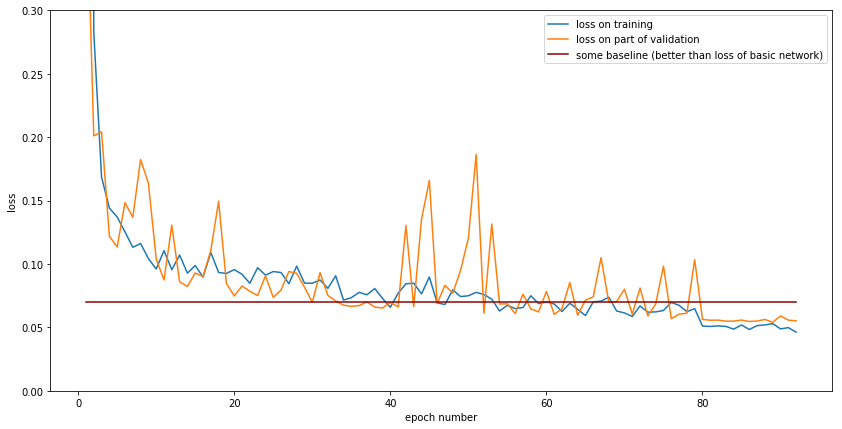

In [36]:
from IPython.display import clear_output
try:
    for epoch_i in range(num_epochs):
        sched1.step()
        sched2.step()
        sched3.step()
        print('Training:')
        train_loss = train_mae = train_batches = 0    
        model.train(True)
        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))
            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.data.numpy()
            train_mae += compute_mae(reference, prediction).data.numpy()
            train_batches += 1
        mae_history_train.append(train_mae / train_batches)
        loss_history_train.append(train_loss / train_batches)

        print("Validation:")
        val_loss = val_mae = val_batches = 0
        model.train(False)

        for batch in iterate_minibatches(data_val, max_batches=val_batches_limit, shuffle=False):
            with torch.no_grad():
                title_ix = Variable(torch.LongTensor(batch["Title"]))
                desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
                cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
                reference = Variable(torch.FloatTensor(batch[target_column]))
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1
        mae_history_val.append(val_mae / val_batches)
        loss_history_val.append(val_loss / val_batches)
        
        clear_output(True)
        
        plt.figure(figsize=(14, 7))
        plt.plot(np.arange(len(loss_history_train)) + 1, loss_history_train, label='loss on training')
        plt.plot(np.arange(len(loss_history_val)) + 1, loss_history_val, label='loss on part of validation')
        plt.plot(np.arange(len(loss_history_val)) + 1, np.ones(len(loss_history_val)) * 0.07, 
                 label = 'some baseline (better than loss of basic network)', color = 'darkred')
        plt.ylabel('loss')
        plt.xlabel('epoch number')
        plt.legend()
        plt.ylim(0, 0.3)
        plt.show()
except KeyboardInterrupt:
    pass

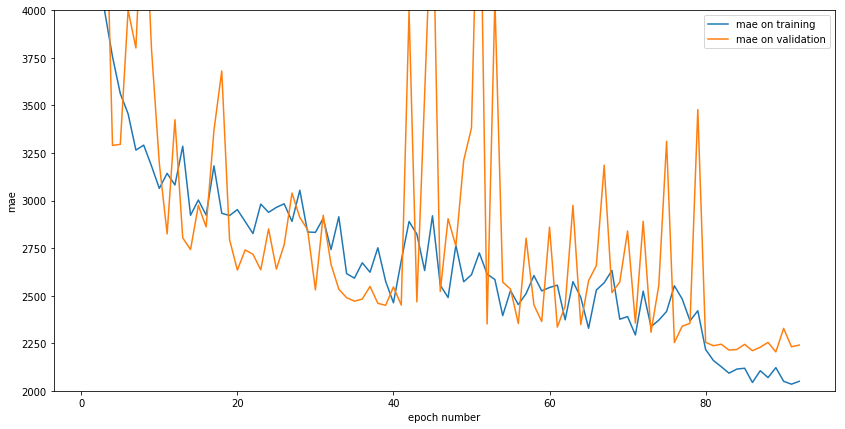

In [38]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(mae_history_train)) + 1, mae_history_train, label='mae on training')
plt.plot(np.arange(len(mae_history_val)) + 1, mae_history_val, label='mae on validation')
plt.ylabel('mae')
plt.xlabel('epoch number')
plt.legend()
plt.ylim(2000, 4000)
plt.show()

In [40]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
model.train(False)

for batch in iterate_minibatches(data_val, shuffle=False):
    with torch.no_grad():
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()
    val_mae += compute_mae(reference, prediction).data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.05751
	MAE:	2266.33950





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

# Отчёт.

На всех графиках для валидационного множества значения MAE и loss-а считались на первых 100 батчах (достаточно, чтобы видеть примерную картину, но при этом быстрее, чем каждую эпоху прогонять всю валидационную выборку), прошу прощения за опечатку в легенде для MAE. 

Все финальные значения loss и MAE на валидационном множестве выписывал ручкой на бумажку, ручаюсь за них. Сразу же вставил одноразовое уменьшение lr по расписанию. Только в финальной версии попробовал агрессивный способ, где сеть учится с 4 разными lr.

1) В первую очередь я поставил 150 батчей на эпоху (глянул видео семинара и подумал, что надо сделать значение побольше, потом так и оставил). Базовая модель дала в итоге MAE = 2587.67746, loss = 0.07455. 

2) Сразу попробовал использовать общую матрицу эмбеддингов (TextEncoder) для Title и Description. Это заметно ускорило обучение и дало значения: MAE = 2562.915, loss = 0.07455. Думаю, дело в том, что общая матрица обучается более "интенсивно", чем 2 матрицы по отдельности, к тому же матрица эмбеддингов Title будет иметь более скудный "словарный запас", что тоже не способствует качественному обучению. Эта идея мне понравилась из остальных больше всего, потому что w2v возвращает векторы фиксированной размерности, да и памяти займёт прилично. А дообучать предобученные эмбеддинги я поленился :), да и показалось, что потихоньку оба варианта начнут сходиться к тому же, да и к тому же в самом конце с общей обучаемой матрицей получился неплохой результат. 

3) Потом взялся за добавление слоёв, параллельных свёрток, батчнормов и дропаутов. Батч-нормализация почему-то всё портила, loss взлетал, и от неё я сразу отказался (MAE > 3000). Dropout на обучении делал loss и MAE больше, а при .train(False) значения приходили в порядок, но прорыва в повышении качества не было, как и повышения вообще, поэтому я убрал (если смотреть код класса TextEncoder, то там можно увидеть закомменированные слои и их применение). Для обработки категориальных признаков и выходом пулинга я сделал по 2 слоя, между которыми ReLU, вместо одного полносвязного. Этот случай отдельным запуском не проверял, но потом запустил, когда добавил параллельных свёрток для Title и Description (сначала по 2). MAE = 2491.04784, loss = 0.06934. Тут, думается, улучшение качества достигается за счёт различных способов преобразования входной информации параллельными свёртками, которые настраиваются по ходу обучения, ну и учеличение слоёв тоже должно было немного повлиять.

4) Реализовал приведённые пулинги (2 attentive - двуслойный и однослойный - вдруг оба пригодятся, большее число слоёв посчитал бессмысленным). Сначала пробовал average, softmax - прорыва в улучшении метрики не было. Но потом, когда взял однослойный attentive pooling для Description - качество выросло до loss=0.064, MAE = 2403.61948. Тут логично, что настраивание весов, с которыми значения суммируются по time, должно положительно влиять на качество.

5) В итоговый, который не планировался как итоговый, вариант, добавил для текстовых полей по одной двусторонней однослойной LSTM, для которых применял самый перспективный attentive pooling. Свёртки решил оставить, а также поиграться немного с размером ядра, и на вход линейным слоям приходили конкатенации "отпулингованных" выходов и свёрток, и rnn. Пулинги оставил почти все в надежде, что каждый вносит свой вклад в достижение приемлемого качетсва. В результате получились результаты: loss = 0.05751 MAE = 2266.33950. Тут, похоже, всё дело в том, что rnn лучше справляется с обработкой последовательностей. 

С учётом того, что большинство способ я перепробовал, при этом достиг неплохого улучшения базовой модели, свою задачу я посчитал выполненной. Ещё можно было попробовать БОЛЬШЕ СЛОЁВ ДЛЯ LSTM И ЕЩЁ БОЛЬШЕ НЕЙРОНОВ, но и так сойдет. :)